In [16]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from numpy import set_printoptions
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sn

In [17]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

Initial preprocessing of the data, we had to remove columns with over 1000 missing values for the analysis to work.

In [41]:
ames_data = pd.read_csv("AmesHousing.csv")
is_na_mask = ames_data.isna().sum()
missing_columns = is_na_mask[is_na_mask > 1000].index #these are the columns with over 1000 missing values, I want them gone
ames_data.drop(columns = missing_columns, inplace = True)
ames_data.dropna(inplace=True)

We will now separate the data into numerical data, categorical data, and a combination of the two.

In [42]:
#the numerical data
numerical_columns = [val for val in ames_data.describe().columns if val not in ["SalePrice"]]
numerical_ames_data = ames_data[numerical_columns]
numerical_ames_data = numerical_ames_data.dropna()

In [43]:
#the categorical and combined data
#learned how to encode categorical columns from: https://medium.com/byteridge/encoding-categorical-values-in-python-scikit-learn-51b04b4bb5fa
categorical_columns = [val for val in ames_data.columns if val not in ames_data.describe().columns]
categorical_df = ames_data[categorical_columns]
le = LabelEncoder()
encoded_categorical_df = categorical_df.astype(str).apply(le.fit_transform) #essentially this is transforming the categorical data into numerical 
combined_df = encoded_categorical_df.join(numerical_ames_data)#the encoded categorical data + the numerical data

This Best Features Class makes it very easy to extract the most significant features of a given dataset (numerical data, categorical data, combined data). We used the Random Forest and univariate feature selection techniques.

In [44]:
class Best_Features:
    '''Extracts the most important features in predicting house sale price using random forest and univariate selection techniques'''
    def __init__(self, k, input_df):
        '''K is the number of features you want displayed, input_df is the particular dataframe you're using'''
        self.k = k
        self.input_df = input_df
    
    def features_and_labels_generator(self):
        '''Splits the input dataframe into feature and label vectors'''
        feature_columns = self.input_df.columns
        feature_vectors = np.array(self.input_df[feature_columns])
        class_labels = np.array(ames_data["SalePrice"])
        return (feature_vectors, class_labels)
        
    def univariate_feature_selector(self):
        '''returns k best features for dataset based on univariate selection'''
        x,y = self.features_and_labels_generator()
        fs = SelectKBest(score_func=f_regression, k=self.k)
        # apply feature selection
        fit = fs.fit_transform(x, y)
        univariate_feature_columns = self.input_df.columns[fs.get_support(indices=True)]
        return univariate_feature_columns
    
    def random_forest_feature_selector(self):
        '''returns k best features for dataset based on random forest model'''
        x,y = self.features_and_labels_generator()
        total_x_train, total_x_test, total_y_train, total_y_test = train_test_split(x, y, test_size=0.25)
        feat_select_clf = RandomForestRegressor(n_estimators = 100, random_state=0)
        feat_select_clf.fit(total_x_train, total_y_train)
        important_features = list(zip(self.input_df.columns,feat_select_clf.feature_importances_))
        important_features.sort(key = lambda pair: pair[1], reverse = True)
        random_f_best_features = [pair[0] for pair in important_features[0:self.k]]
        return random_f_best_features
    
    def total_best_features(self):
        '''returns dataframe of intersection of univariate and random_forest features'''
        univariate_best_features = self.univariate_feature_selector()
        random_f_best_features = self.random_forest_feature_selector()
        total_best_features = list(set(univariate_best_features) & set(random_f_best_features))
        best_features_df = self.input_df[total_best_features]
        return best_features_df

In [45]:
numerical_features_obj = Best_Features(k=25,input_df=numerical_ames_data)
best_numerical_features = numerical_features_obj.total_best_features()

In [46]:
categorical_features_obj = Best_Features(k=25,input_df=encoded_categorical_df)
best_categorical_features = categorical_features_obj.total_best_features()

In [47]:
combined_features_obj = Best_Features(k=25, input_df=combined_df)
best_combined_features = combined_features_obj.total_best_features()

In [48]:
best_combined_features.columns

Index(['Garage Area', 'Kitchen Qual', 'Full Bath', 'Gr Liv Area',
       'Garage Yr Blt', 'Year Built', 'Mas Vnr Area', 'TotRms AbvGrd',
       'Open Porch SF', 'Total Bsmt SF', '1st Flr SF', 'BsmtFin SF 1',
       'Garage Cars', 'Year Remod/Add', 'Overall Qual', 'Lot Frontage'],
      dtype='object')

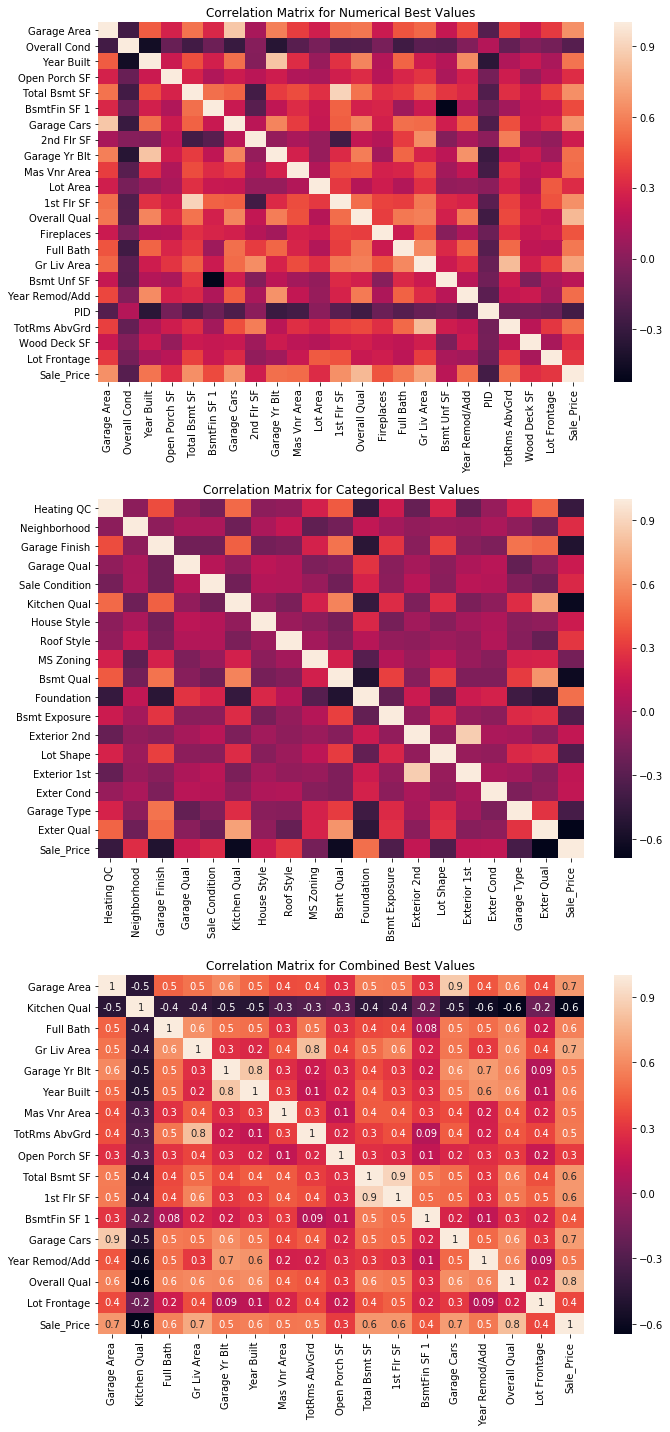

In [49]:
#correation matrix 
corr_data_num = best_numerical_features.copy()
corr_data_num['Sale_Price'] = ames_data['SalePrice']
corr_data_num_matrix = corr_data_num.corr()

corr_data_categorical = best_categorical_features.copy()
corr_data_categorical['Sale_Price'] =  ames_data['SalePrice']
corr_data_categorical_matrix = corr_data_categorical.corr()

corr_data_combined = best_combined_features.copy()
corr_data_combined['Sale_Price'] =  ames_data['SalePrice']
corr_data_combined_matrix = corr_data_combined.corr()



plt.figure(figsize=(10,20))


plt.subplot(3,1,1)
sn.heatmap(corr_data_num_matrix)
plt.title("Correlation Matrix for Numerical Best Values")


plt.subplot(3,1,2)
sn.heatmap(corr_data_categorical_matrix)
plt.title("Correlation Matrix for Categorical Best Values")
plt.tight_layout()

plt.subplot(3,1,3)
sn.heatmap(corr_data_combined_matrix, annot = True, fmt = '.1g')
plt.title("Correlation Matrix for Combined Best Values")
plt.tight_layout()




In [50]:
def random_forest_predictor(input_features, input_labels = ames_data["SalePrice"]):
    '''function that takes in the best features for a given dataframe and returns the r squared value 
    as well as the root mean squared error using Random Forest Regression'''
    X_train, X_test, y_train, y_test = train_test_split(input_features, input_labels, test_size=0.25)
    regr = RandomForestRegressor(n_estimators=100, random_state=0)
    regr.fit(X_train, y_train)
    y_pred = regr.predict(X_test)
    root_mean_squared_error = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    r_squared_value = metrics.r2_score(y_test, y_pred)
    return (root_mean_squared_error, r_squared_value)

In [51]:
r2_list = []
error_list = []
feature_list = [best_categorical_features, best_numerical_features, best_combined_features]
label_list = ["Categorical Only", "Numerical Only", "Both"]

for feature_df in feature_list:
    error, r2 = random_forest_predictor(input_features=feature_df)
    r2_list.append(r2)
    error_list.append(error)

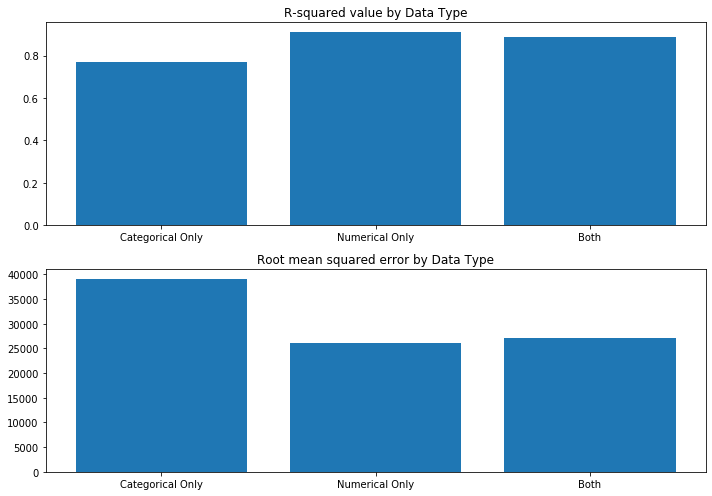

In [53]:
plt.figure(figsize=(10,7))


plt.subplot(2,1,1)
plt.bar(label_list, r2_list)
plt.title("R-squared value by Data Type")


plt.subplot(2,1,2)
plt.bar(label_list, error_list)
plt.title("Root mean squared error by Data Type")
plt.tight_layout()


So for the features for your chosen model, you can use either the best_numerical_features, best_categorical_features, or best_combined_features variables. The labels will be ames_data["SalePrice"].

In [55]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split

def Linear_Regression(input_features, input_labels = ames_data['SalePrice']):
    #X is the chosen catergories that are going to be used for prediction
    X = input_features
    #y is the sales price
    y = input_labels

    #Splitting the data into training and testing
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

    #Using linear regression model to fit the data
    reg = linear_model.LinearRegression()
    reg.fit(X_train, y_train)
    
    y_pred = reg.predict(X_test)
    root_mean_squared_error = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    
    #returns the R^2 of the predicted based on X_test and the actual y_test
    return root_mean_squared_error, reg.score(X_test, y_test)

In [56]:
r2_linear = []
error_linear = []
feature_list = [best_categorical_features, best_numerical_features, best_combined_features]
label_list = ["Categorical Only", "Numerical Only", "Both"]

for feature_df in feature_list:
    error, r2 = Linear_Regression(input_features=feature_df)
    r2_linear.append(r2)
    error_linear.append(error)

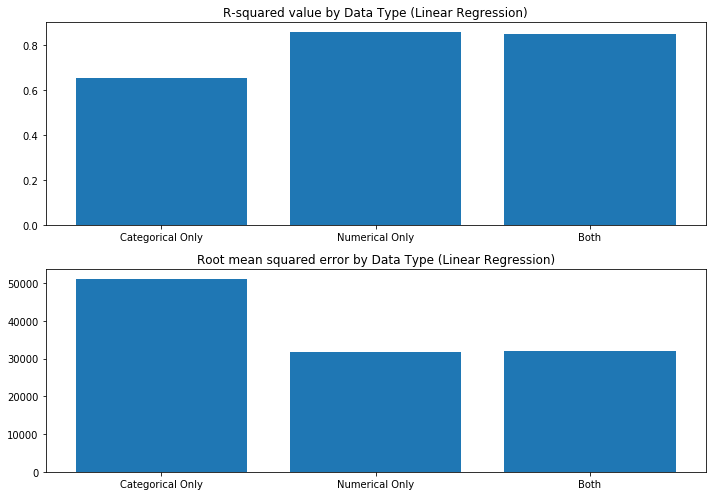

In [57]:
plt.figure(figsize=(10,7))


plt.subplot(2,1,1)
plt.bar(label_list, r2_linear)
plt.title("R-squared value by Data Type (Linear Regression)")


plt.subplot(2,1,2)
plt.bar(label_list, error_linear)
plt.title("Root mean squared error by Data Type (Linear Regression)")
plt.tight_layout()
